# Model Training

---



After obtaining all the features, we will first perform feature selection on the features that we are interested in.



In [ ]:
# obtain dataset from csv mounted on drive, so that feature engineering need not be ran every time
from google.colab import drive
import pandas as pd

drive.mount('/drive')
final_df = pd.read_csv('/drive/My Drive/BT4222 Project/final_df_14_04_2025_1631.csv')

Mounted at /drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

#### Feature selection of numeric features

In [ ]:
# Load your dataframe
df = final_df

# Select only numeric columns (int64 and float64), excluding 'label' and also columns that are deemed to not provide any real predictive power based on domain knowlegde
df = df.drop(columns=['Unnamed: 0'], errors='ignore')
df = df.drop(columns=[col for col in df.columns if col.startswith('publish')])
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
feature_cols = numeric_cols.drop('label')

X = df[feature_cols]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:40:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


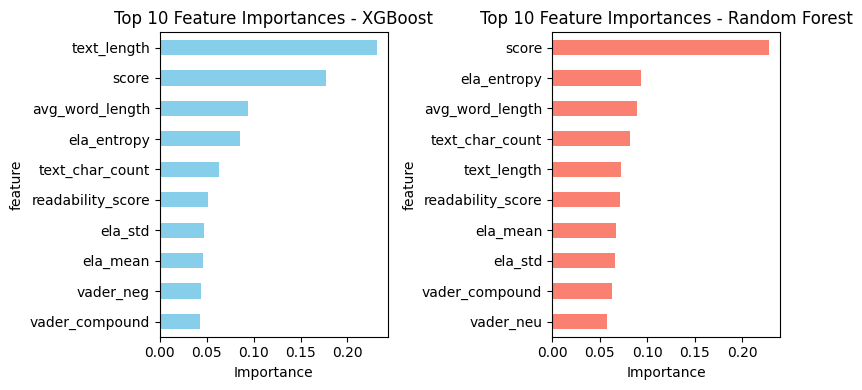

In [ ]:
# Train XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

xgb_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# --- Train Random Forest ---
rf = RandomForestClassifier(criterion='entropy', n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

rf_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# XGBoost plot
xgb_importance_df.head(10).plot(kind='barh', x='feature', y='importance', ax=axes[0], legend=False, color='skyblue')
axes[0].invert_yaxis()
axes[0].set_title('Top 10 Feature Importances - XGBoost')
axes[0].set_xlabel('Importance')

# Random Forest plot
rf_importance_df.head(10).plot(kind='barh', x='feature', y='importance', ax=axes[1], legend=False, color='salmon')
axes[1].invert_yaxis()
axes[1].set_title('Top 10 Feature Importances - Random Forest')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()


In [ ]:
# Display top features
print("XGB")
print(xgb_importance_df)
print()
print("Random Forest")
print(rf_importance_df)

XGB
              feature  importance
1         text_length    0.231089
0               score    0.177108
3     avg_word_length    0.094560
12        ela_entropy    0.085547
2     text_char_count    0.062890
4   readability_score    0.051900
10            ela_std    0.046844
9            ela_mean    0.046349
5           vader_neg    0.044484
8      vader_compound    0.042468
6           vader_neu    0.040697
11            ela_max    0.039113
7           vader_pos    0.036951

Random Forest
              feature  importance
0               score    0.228642
12        ela_entropy    0.094119
3     avg_word_length    0.089251
2     text_char_count    0.081949
1         text_length    0.072485
4   readability_score    0.071031
9            ela_mean    0.067132
10            ela_std    0.066032
8      vader_compound    0.062553
6           vader_neu    0.058025
5           vader_neg    0.052394
7           vader_pos    0.050989
11            ela_max    0.005400


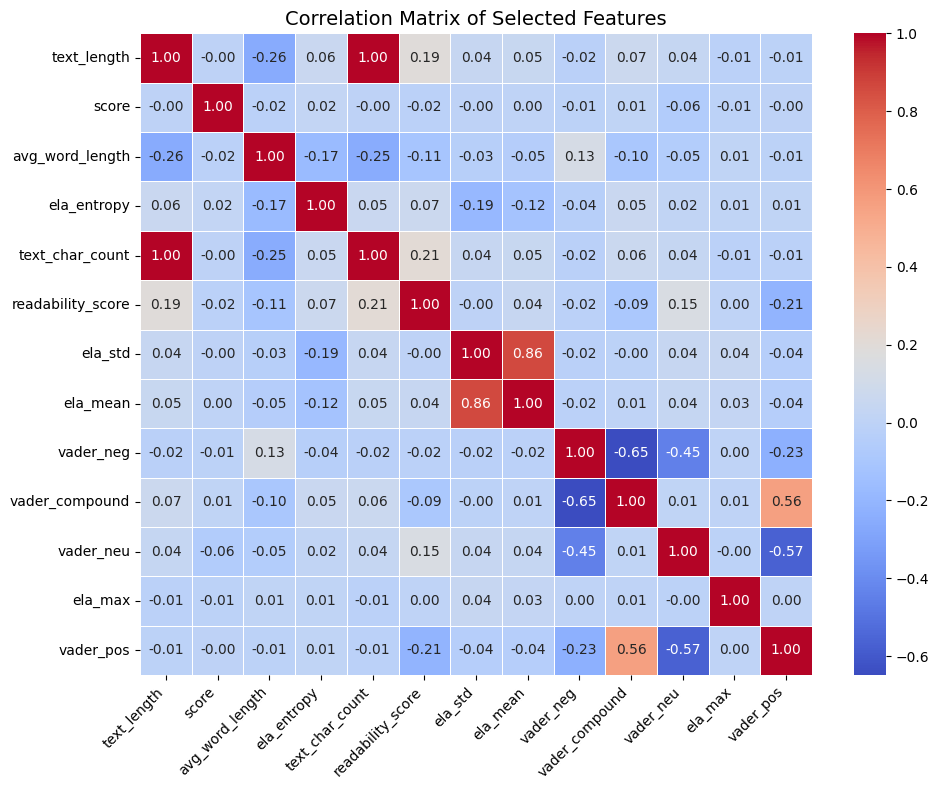

In [ ]:
selected_features = [
    'text_length', 'score', 'avg_word_length', 'ela_entropy', 'text_char_count',
    'readability_score', 'ela_std', 'ela_mean', 'vader_neg', 'vader_compound',
    'vader_neu', 'ela_max', 'vader_pos'
]

corr_matrix = df[selected_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Selected Features", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


From the above feature selection process, based off results from both the XGBoost and Random Forest models and the correlation matrix above, we have decided to remove the follow features:

1. text_char_count --> due to perfect correlation with text_length
2. ela_mean --> due to high correlation with ela_std
3. vader_neg + vader_pos --> due to high correlation with vader_compound and low feature importance

In [ ]:
# @title v5 (additional features)
class MCNN_Precomputed(nn.Module):
    def __init__(self):
        super(MCNN_Precomputed, self).__init__()

        # Projections for existing features (text, image, readability, etc.)
        self.text_proj = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.LayerNorm(512)
        )

        self.image_proj = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.LayerNorm(512)
        )

        self.readability_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        self.ela_proj = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.LayerNorm(128)
        )

        self.sentiment_proj = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.LayerNorm(64)
        )

        self.similarity_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        # Projections for additional features
        self.avg_word_count_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        self.avg_word_length_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        self.score_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        # Attention layers
        self.text_attention = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)
        self.image_attention = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)

        # Cross-modal attention
        self.text_to_image_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)
        self.image_to_text_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)

        # Feedforward after attention
        self.text_ffn = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.image_ffn = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.text_norm = nn.LayerNorm(512)
        self.image_norm = nn.LayerNorm(512)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 + 512 + 128 + 64 + 16 * 5, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)
        )

    def forward(self, bert_emb, cnn_emb, readability_features, ela_features, sentiment_features, avg_word_count, avg_word_length, score):
        # Projections for existing features
        text_feat = self.text_proj(bert_emb)
        img_feat = self.image_proj(cnn_emb)
        readability_feat = self.readability_proj(readability_features.view(-1, 1))
        ela_feat = self.ela_proj(ela_features)
        sentiment_feat = self.sentiment_proj(sentiment_features)
        sim_feat = self.similarity_proj(F.cosine_similarity(text_feat, img_feat, dim=1).unsqueeze(1))

        # Projections for additional features
        avg_word_count_feat = self.avg_word_count_proj(avg_word_count.view(-1, 1))
        avg_word_length_feat = self.avg_word_length_proj(avg_word_length.view(-1, 1))
        score_feat = self.score_proj(score.view(-1, 1))

        # Add sequence dimension for attention
        text_seq = text_feat.unsqueeze(1)
        img_seq = img_feat.unsqueeze(1)

        text_attn_out, _ = self.text_attention(text_seq, text_seq, text_seq)
        text_attn = self.text_norm(text_attn_out + self.text_ffn(text_attn_out))
        img_attn_out, _ = self.image_attention(img_seq, img_seq, img_seq)
        img_attn = self.image_norm(img_attn_out + self.image_ffn(img_attn_out))

        # Remove sequence dimension
        text_attn_out = text_attn_out.squeeze(1)
        img_attn_out = img_attn_out.squeeze(1)

        # Concatenation
        combined = torch.cat([
            text_attn_out, img_attn_out, readability_feat, ela_feat, sentiment_feat, sim_feat,
            avg_word_count_feat, avg_word_length_feat, score_feat
        ], dim=1)

        logits = self.classifier(combined)
        return logits


def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    best_val_acc = 0.0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for bert, cnn, read, ela, sentiment, avg_word_count, avg_word_length, score, labels in tqdm(train_loader):
            # Move the data to the correct device (e.g., 'cuda' or 'cpu')
            bert, cnn, read, ela, sentiment, avg_word_count, avg_word_length, score, labels = (
                bert.to(device), cnn.to(device), read.to(device), ela.to(device), sentiment.to(device),
                avg_word_count.to(device), avg_word_length.to(device), score.to(device), labels.to(device)
            )

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(bert, cnn, read, ela, sentiment, avg_word_count, avg_word_length, score)

            # Calculate the loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track the running loss and accuracy
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        # Calculate training accuracy
        train_acc = correct / total

        # Validate the model
        val_acc = evaluate(model, val_loader, device)

        # Print training and validation stats
        print(f"Train Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_mcnn_model.pth")
            plateau_count = 0
        else:
            plateau_count += 1

        # Early stopping to prevent overfitting
        if plateau_count >= 5:
            print("Early stopping triggered")
            break
def evaluate(model, dataloader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for bert, cnn, read, ela, sentiment, avg_word_count, avg_word_length, score, labels in dataloader:
            # Move the data to the correct device (e.g., 'cuda' or 'cpu')
            bert, cnn, read, ela, sentiment, avg_word_count, avg_word_length, score, labels = (
                bert.to(device), cnn.to(device), read.to(device), ela.to(device), sentiment.to(device),
                avg_word_count.to(device), avg_word_length.to(device), score.to(device), labels.to(device)
            )

            # Forward pass
            outputs = model(bert, cnn, read, ela, sentiment, avg_word_count, avg_word_length, score)

            # Get predictions and compute accuracy
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # Return accuracy
    return correct / total


### creating train val test

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import ast

# Initial train/test split
train_df, temp_df = train_test_split(final_df, test_size=0.2, stratify=final_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

class MCNNDataset(Dataset):
    def __init__(self, dataframe):
        # Text and image embeddings
        self.bert = torch.tensor(dataframe['bert_embeddings'].apply(ast.literal_eval).tolist(), dtype=torch.float32)
        self.cnn = torch.tensor(dataframe['cnn_embeddings'].apply(ast.literal_eval).tolist(), dtype=torch.float32)

        # Readability score
        self.read = torch.tensor(dataframe['readability_score'].values, dtype=torch.float32)

        # ELA features
        self.ela = torch.tensor(dataframe[['ela_std', 'ela_max', 'ela_entropy']].values, dtype=torch.float32)

        # Sentiment features
        self.sentiment = torch.tensor(dataframe[['vader_neu', 'vader_compound']].values, dtype=torch.float32)

        # Additional features
        self.avg_word_count = torch.tensor(dataframe['text_length'].values, dtype=torch.float32)  # New feature
        self.avg_word_length = torch.tensor(dataframe['avg_word_length'].values, dtype=torch.float32)  # New feature
        self.score = torch.tensor(dataframe['score'].values, dtype=torch.float32)  # New feature

        # Labels
        self.labels = torch.tensor(dataframe['label'].values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            self.bert[idx], self.cnn[idx], self.read[idx], self.ela[idx], self.sentiment[idx],
            self.avg_word_count[idx], self.avg_word_length[idx], self.score[idx], self.labels[idx]
        )
# Instantiate datasets
train_dataset = MCNNDataset(train_df)
val_dataset = MCNNDataset(val_df)
test_dataset = MCNNDataset(test_df)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
len(train_df)

11676

In [ ]:
sum(train_df['label'])

5582

### retrain model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate model and move to device
model = MCNN_Precomputed().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Using device: cuda


In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=20)


Epoch 1/20


100%|██████████| 365/365 [00:05<00:00, 68.10it/s]


Train Loss: 192.7550 | Train Acc: 0.7141 | Val Acc: 0.7368

Epoch 2/20


100%|██████████| 365/365 [00:03<00:00, 94.68it/s]


Train Loss: 139.4755 | Train Acc: 0.8141 | Val Acc: 0.7896

Epoch 3/20


100%|██████████| 365/365 [00:04<00:00, 79.97it/s]


Train Loss: 120.2836 | Train Acc: 0.8394 | Val Acc: 0.8136

Epoch 4/20


100%|██████████| 365/365 [00:04<00:00, 83.76it/s]


Train Loss: 109.4225 | Train Acc: 0.8557 | Val Acc: 0.8177

Epoch 5/20


100%|██████████| 365/365 [00:03<00:00, 92.57it/s]


Train Loss: 100.1364 | Train Acc: 0.8678 | Val Acc: 0.8245

Epoch 6/20


100%|██████████| 365/365 [00:04<00:00, 82.75it/s]


Train Loss: 91.1576 | Train Acc: 0.8810 | Val Acc: 0.8328

Epoch 7/20


100%|██████████| 365/365 [00:03<00:00, 95.37it/s]


Train Loss: 86.4306 | Train Acc: 0.8870 | Val Acc: 0.8191

Epoch 8/20


100%|██████████| 365/365 [00:03<00:00, 93.39it/s]


Train Loss: 78.6944 | Train Acc: 0.8964 | Val Acc: 0.8314

Epoch 9/20


100%|██████████| 365/365 [00:04<00:00, 80.83it/s]


Train Loss: 73.8650 | Train Acc: 0.9034 | Val Acc: 0.8348

Epoch 10/20


100%|██████████| 365/365 [00:03<00:00, 95.69it/s]


Train Loss: 69.4149 | Train Acc: 0.9096 | Val Acc: 0.8307

Epoch 11/20


100%|██████████| 365/365 [00:03<00:00, 94.50it/s]


Train Loss: 65.1074 | Train Acc: 0.9146 | Val Acc: 0.8328

Epoch 12/20


100%|██████████| 365/365 [00:05<00:00, 72.69it/s]


Train Loss: 60.4100 | Train Acc: 0.9215 | Val Acc: 0.8204

Epoch 13/20


100%|██████████| 365/365 [00:03<00:00, 95.56it/s]


Train Loss: 56.2152 | Train Acc: 0.9252 | Val Acc: 0.8067

Epoch 14/20


100%|██████████| 365/365 [00:04<00:00, 90.88it/s]


Train Loss: 55.7466 | Train Acc: 0.9298 | Val Acc: 0.8314
Early stopping triggered


## Evaluation

In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

def evaluate_with_stats(model, dataloader, device='cuda'):
    model.eval()
    correct, total = 0, 0
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for (
            bert, cnn, read, ela, sentiment,
            avg_word_count, avg_word_length,
            score, labels
        ) in tqdm(dataloader, desc="Evaluating", total=len(dataloader)):

            bert, cnn, read, ela, sentiment = bert.to(device), cnn.to(device), read.to(device), ela.to(device), sentiment.to(device)
            avg_word_count, avg_word_length = avg_word_count.to(device), avg_word_length.to(device)
            score, labels = score.to(device), labels.to(device)

            outputs = model(
                bert, cnn, read, ela, sentiment,
                avg_word_count, avg_word_length,
                score
            )
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # For binary class, get probability of class 1
            all_labels.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    cm = confusion_matrix(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"\nAccuracy: {acc:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print("Confusion Matrix:\n", cm)

    return acc, auc, cm, all_labels, all_preds, all_probs


def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


def plot_classification_report(y_true, y_pred, labels):
    report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    df = pd.DataFrame(report).transpose().drop('accuracy')
    df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
    plt.title('Precision, Recall, F1-Score per Class')
    plt.xticks(rotation=0, ha='center')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.legend(bbox_to_anchor=(1.15, 1), loc="upper right")
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_probs):
  fpr, tpr, thresholds = roc_curve(y_true, y_probs)
  auc_score = roc_auc_score(y_true, y_probs)

  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
  plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curve")
  plt.legend(loc="lower right")
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.tight_layout()
  plt.show()


Evaluating: 100%|██████████| 365/365 [00:01<00:00, 214.20it/s]



Accuracy: 0.9410
AUC-ROC: 0.9924
Confusion Matrix:
 [[5489  605]
 [  84 5498]]

Train Accuracy: 0.9410


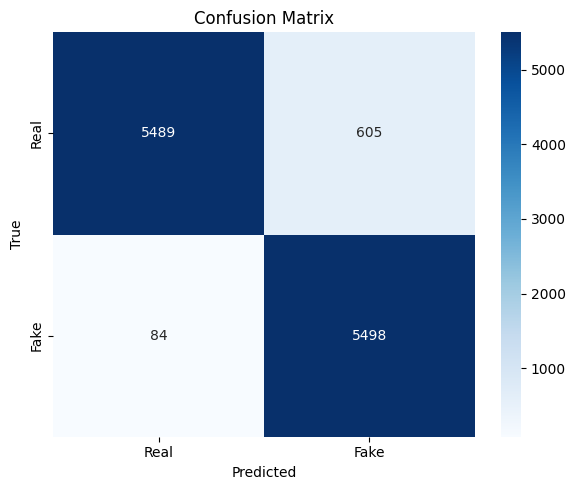

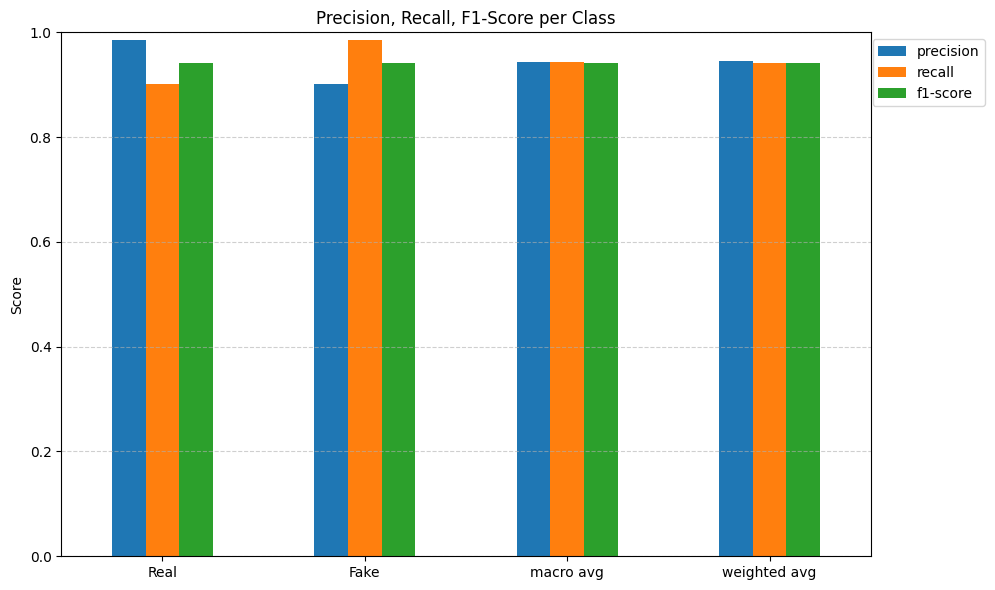

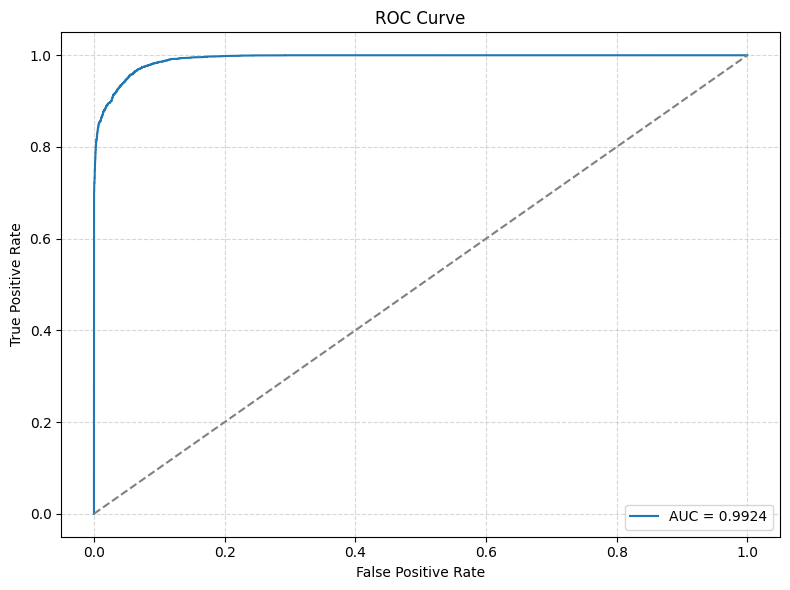

In [ ]:
acc, auc, cm, y_true, y_pred, y_probs = evaluate_with_stats(model, train_loader, device=device)
print(f"\nTrain Accuracy: {acc:.4f}")
labels=['Real', 'Fake']
plot_confusion_matrix(cm, labels)
plot_classification_report(y_true, y_pred, labels)
plot_roc_curve(y_true, y_probs)

In [ ]:
classification_report(y_true, y_pred, target_names=labels, output_dict=True)

{'Real': {'precision': 0.984927328189485,
  'recall': 0.9007220216606499,
  'f1-score': 0.9409445444415874,
  'support': 6094.0},
 'Fake': {'precision': 0.9008684253645748,
  'recall': 0.9849516302400573,
  'f1-score': 0.9410355156183141,
  'support': 5582.0},
 'accuracy': 0.9409900650907845,
 'macro avg': {'precision': 0.94289787677703,
  'recall': 0.9428368259503536,
  'f1-score': 0.9409900300299507,
  'support': 11676.0},
 'weighted avg': {'precision': 0.9447408948588367,
  'recall': 0.9409900650907845,
  'f1-score': 0.9409880354580732,
  'support': 11676.0}}

Evaluating: 100%|██████████| 46/46 [00:00<00:00, 246.87it/s]



Accuracy: 0.8418
AUC-ROC: 0.9338
Confusion Matrix:
 [[602 160]
 [ 71 627]]

Test Accuracy: 0.8418


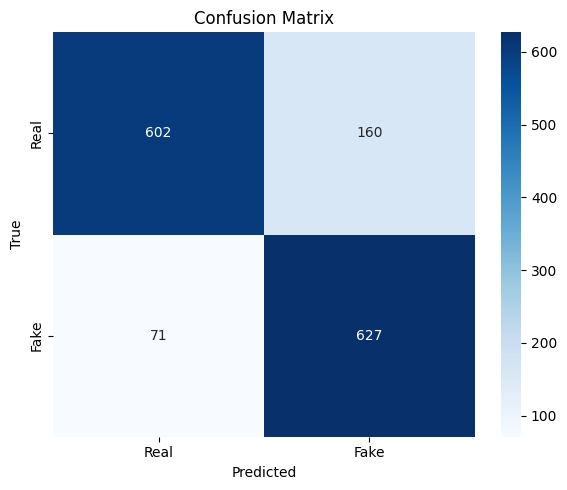

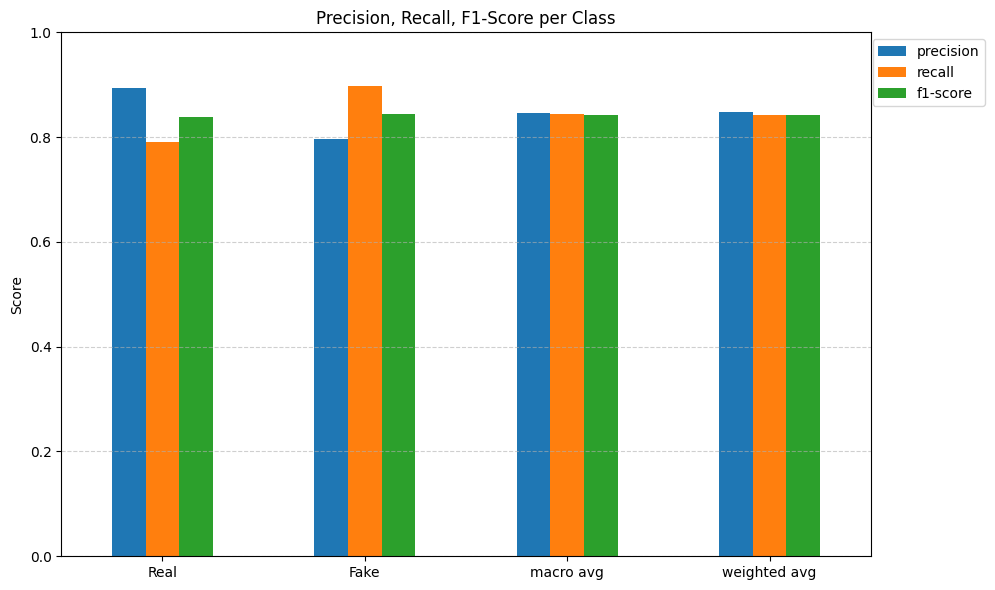

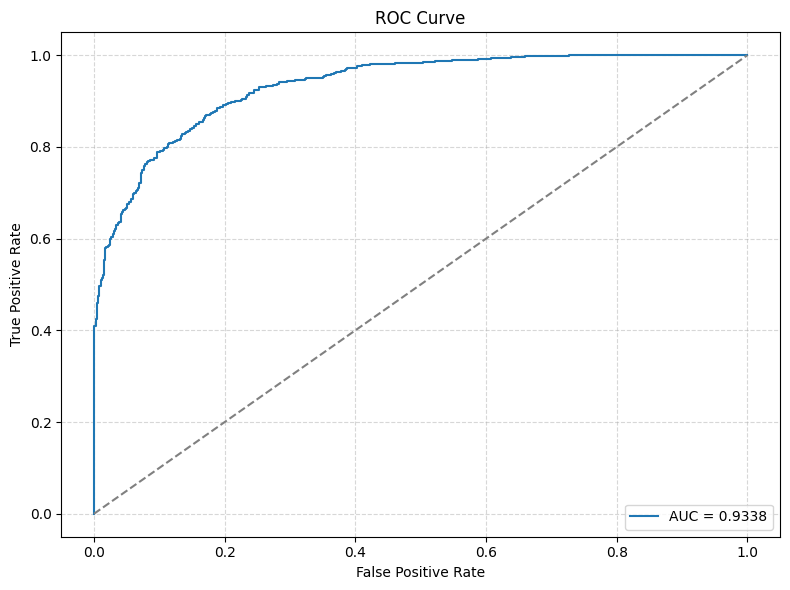

In [ ]:
acc, auc, cm, y_true, y_pred, y_probs = evaluate_with_stats(model, test_loader, device=device)
print(f"\nTest Accuracy: {acc:.4f}")
labels=['Real', 'Fake']
plot_confusion_matrix(cm, labels)
plot_classification_report(y_true, y_pred, labels)
plot_roc_curve(y_true, y_probs)

In [ ]:
classification_report(y_true, y_pred, target_names=labels, output_dict=True)

{'Real': {'precision': 0.8945022288261516,
  'recall': 0.7900262467191601,
  'f1-score': 0.8390243902439024,
  'support': 762.0},
 'Fake': {'precision': 0.7966963151207116,
  'recall': 0.8982808022922636,
  'f1-score': 0.8444444444444444,
  'support': 698.0},
 'accuracy': 0.8417808219178082,
 'macro avg': {'precision': 0.8455992719734315,
  'recall': 0.8441535245057119,
  'f1-score': 0.8417344173441734,
  'support': 1460.0},
 'weighted avg': {'precision': 0.8477429632327289,
  'recall': 0.8417808219178082,
  'f1-score': 0.8416156216356684,
  'support': 1460.0}}